# Tutorial 8: Classification Tree

In [2]:
from importlib import reload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sys
import os
import re
from PIL import Image
from collections import defaultdict

import statsmodels.api as sm
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from scikitplot.metrics import plot_cumulative_gain, plot_roc

In [3]:
FDA_DIR = os.path.join(os.getcwd(), os.pardir, r'PycharmProjects/Financial-Data-Analytics')
DATA_DIR = rf'{FDA_DIR}/Datasets'

def read_file(filename, dir=None, static=False, **kwargs):
    if dir is None:
        dir = DATA_DIR
        
    path = os.path.join(dir, filename)
    extension = filename.rsplit('.', 1)[-1]

    if extension == 'csv':
        return pd.read_csv(path, **kwargs)
    elif extension in ['parq', 'parquet']:
        return pd.read_parquet(path, **kwargs)
    elif extension == 'json':
        with open(path, 'r') as file:
            return json.load(file)
    elif extension == 'xlsx':
        return pd.read_excel(path, **kwargs)
    else:
        raise NotImplementedError

In [4]:
from rpy2.robjects.packages import importr, data
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

def convert_to_R_df(df):
    with ro.conversion.localconverter(ro.default_converter + pandas2ri.converter):
        r_df = ro.conversion.py2rpy(df)
    return r_df

def convert_from_R_df(r_df):
    with ro.conversion.localconverter(ro.default_converter + pandas2ri.converter):
        df = ro.conversion.rpy2py(r_df)
    return df

def fetch_r_data(name, package):
    package = importr(package)
    df = data(package).fetch(name)[name]
    df = convert_from_R_df(df)
    return df

In [5]:
def plot_tree(clf, feature_names=None, class_names=None, 
              title=None, filled=True, figsize=(10, 5), **kwargs):
    if feature_names is None:
        feature_names = clf.feature_names_in_.astype(str)
    if class_names is None:
        class_names = clf.classes_.astype(str)
    
    fig, ax = plt.subplots(figsize=figsize)
    tree.plot_tree(clf, feature_names=feature_names, class_names=class_names, 
                   filled=filled, ax=ax, **kwargs);
    plt.suptitle(title, y=1)
    plt.tight_layout()
    plt.show()


def cost_complexity_pruning(base_clf, X_train, y_train,
        cv=10, scoring='accuracy', skip_one_node=False,
        plot_complexity=True, plot_cv_scores=True, 
        figsize=(12, 5), num_cv_labels=10, **kwargs):

    path = base_clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas = path.ccp_alphas
    clf_dict = defaultdict(dict)
    clf_dict['ccp_alpha'] = ccp_alphas
    
    for ccp_alpha in ccp_alphas:
        if skip_one_node & (ccp_alpha == ccp_alphas[-1]):
            # Skip the trivial tree
            continue
        clf = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha, **kwargs)
        clf_dict['cv_scores'][ccp_alpha] = cross_val_score(clf, X_train, y_train, cv=cv, scoring=scoring)
        clf.fit(X_train, y_train)
        clf_dict['clf'][ccp_alpha] = clf 
        clf_dict['node_counts'][ccp_alpha] = clf.tree_.node_count
        clf_dict['max_depth'][ccp_alpha] = clf.tree_.max_depth

    if plot_complexity:
        fig, ax1 = plt.subplots(figsize=figsize)
        ax2 = ax1.twinx()
        lines = []
        labels = []
        
        for stat, ax, color in zip(['node_counts', 'max_depth'], [ax1, ax2], ['b', 'r']):
            s = pd.Series(clf_dict[stat])
            s.plot(style='.', ax=ax, color=color)
            s.plot(label=stat, drawstyle="steps-post", marker="o", color=color, ax=ax)

            ax_lines, ax_labels = ax.get_legend_handles_labels()
            lines.append(ax_lines)
            labels.append(ax_labels)
            ax.set_ylabel(stat)

        ax1.set_title("Tree Complexity")
        ax1.set_xlabel("alpha")
        ax2.legend(lines[0] + lines[1], labels[0] + labels[1], loc=0)
        plt.show()
        
    if plot_cv_scores:
        cv_scores = pd.DataFrame(clf_dict['cv_scores'])
        cv_scores.plot(kind='box', figsize=figsize, showmeans=True,
                       title=f"{cv}-fold Cross Validation Scores with scoring={scoring}")
        
        step = max(len(cv_scores.columns) // num_cv_labels, 1)
        plt.xticks(ticks=range(1, len(cv_scores.columns) + 1, step), 
                   labels=cv_scores.columns.map(lambda s: f"{s:.4f}")[::step]);
        plt.xlabel("alpha")
        plt.show()

    best_alpha = pd.DataFrame(clf_dict['cv_scores']).mean().idxmax()
    return best_alpha, clf_dict


def confusion_matrix_metrics(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    y_pred = pd.Series(y_pred, index=X_test.index, name='pred')
    conf_mat = y_pred.groupby([y_pred, y_test.rename('truth')]).count().unstack().fillna(0)
    
    test_stat = precision_recall_fscore_support(y_test, y_pred)
    test_stat = pd.DataFrame({stat: score for stat, score in 
                              zip(['precision', 'recall', 'fscore', 'support'], test_stat)})
    return conf_mat, test_stat

In [6]:
def print_param_doc(doc_str, param):
    pattern = re.compile(rf'{param} : (.|\n)*?\n\n    ')
    match = re.search(pattern, doc_str)
    param_doc = match.group()
    param_doc = param_doc.replace(r"\n\n    ", "")
    print(param_doc)

In [7]:
tree_img = os.path.join(FDA_DIR, 'Picture', 'Hypothetical Classification Tree.png')
kyphosis_img = os.path.join(FDA_DIR, 'Picture', 'Cart_tree_kyphosis.png')
why_tree_img = os.path.join(FDA_DIR, 'Picture', 'why_tree.png')

## 1. Introduction

### 1.1. What is a Classification Tree?

Classification Trees are a method that is used to generate a set of simple rules that can be immediately applied to classify observations. 

Suppose we have a collection of variables $x_{i1}, \cdots, x_{ip}$ and we want to predict the classification of a binary outcome variable $y_i$.

This is done by using a process known as binary recursive partitioning. 

Basically, using some or all of the variables, we split the dataset into two sets depending on their values. 

This is done hierarchically, forming a tree structure: 

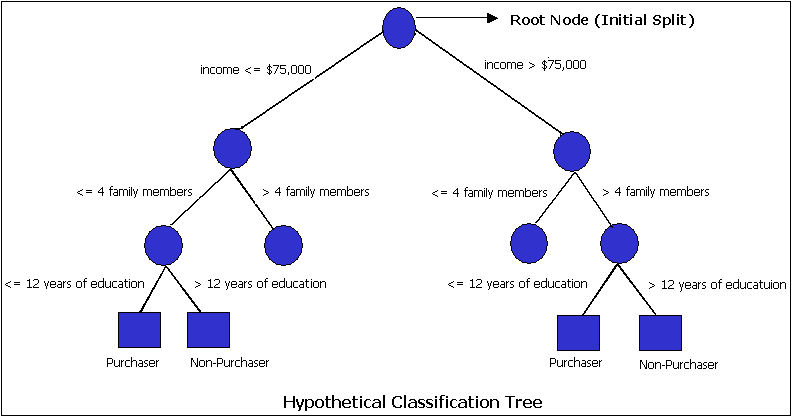

In [11]:
Image.open(tree_img)

### 1.1 Objective


The model fitting problem concerns:

1. What variables to split
2. What values to split each variable
3. How deep should the tree be?

In general, splits are determined so as to cause the largest decrease in diversity for a given partition. 

1. We choose the split which creates two subgroups that are as homogeneous as possible.
2. “Diversity” is characterized by some kind of measure.
3. No split is done if diversity cannot be significantly reduced.

After fitting the classification tree on the training dataset, we then “prune” it to improve its performance on the testing dataset.

Here, “pruning” refers to systematically removing leaves and branches of the tree to reduce the impact of overfitting.

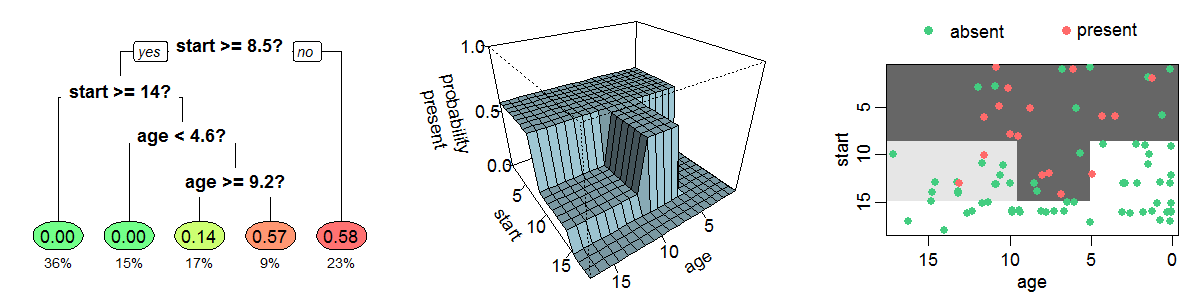

In [14]:
Image.open(kyphosis_img)

### 1.2 Power of Decision Tree

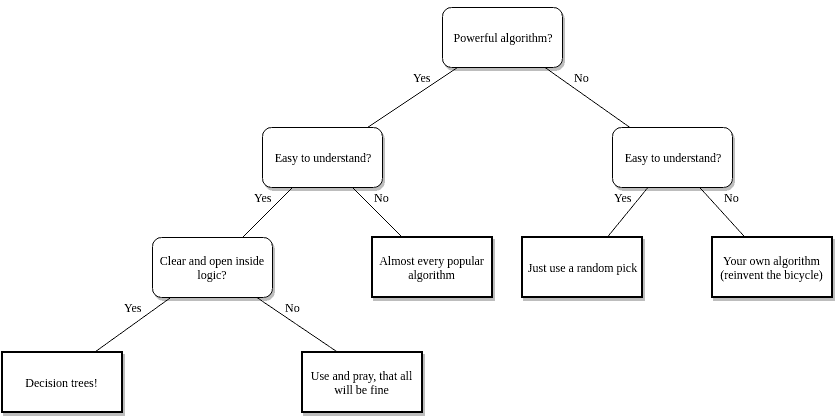

In [16]:
Image.open(why_tree_img)

## 2. Implementation

The Decision Tree selects the model which maximizes some optimization criteria (to be specified) subject to certain complexity costs (also can be specified).

The default is a cost of 1 for each variable in the model. 

### 2.1 HSI Financial Ratio Dataset

The file ```fin-ratio.csv``` contains financial ratios of 680 securities listed on the HKEX in 2002.

There are six financial variables: Earnings yield (```EY```), cash flow to price (```CFTP```), logarithm of market value (```ln_MV```), dividend yield (```DY```), book to market equity (```BTME```), and debt to equity (```DTE```).

Among these companies, there are 32 blue chips which are the Hang Seng index constituent stocks. 

The last column ```HSI``` is a binary variable indicating whether a stock is a bluechip or not.

\
We will fit a classification tree which yields classification rules for whether a listed company is likely to be a bluechip company. 

To fit the classification tree in <b>Python</b>, we use the ```sklearn.tree.DecisionTreeClassifier```

In [21]:
fin_ratio = read_file('fin-ratio.csv')
fin_ratio

,EY,CFTP,ln_MV,DY,BTME,DTE,HSI
0,-1.8292,-0.1732,5.5405,0.000,1.0379,0.2466,0
1,-0.0797,-0.0830,6.8272,0.000,0.1275,25.4606,0
2,-2.2360,-0.6897,5.0102,0.000,-0.2959,3.3263,0
3,-1.5406,-4.1667,4.4954,0.000,-2.8571,0.9148,0
4,-0.9006,-0.3872,4.5031,0.000,2.7981,0.0753,0
...,...,...,...,...,...,...,...
675,0.0772,0.0327,7.9266,4.878,0.3303,0.3948,0
676,0.1447,0.2947,6.9895,3.774,1.6247,0.5565,0
677,0.0394,0.0324,6.9378,1.270,0.8139,0.6896,0
678,0.1153,0.1958,5.7867,0.000,2.9244,0.2420,0


In [22]:
test_size = 0.2
random_state = 12345

X = fin_ratio.drop(columns='HSI')
y = fin_ratio['HSI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

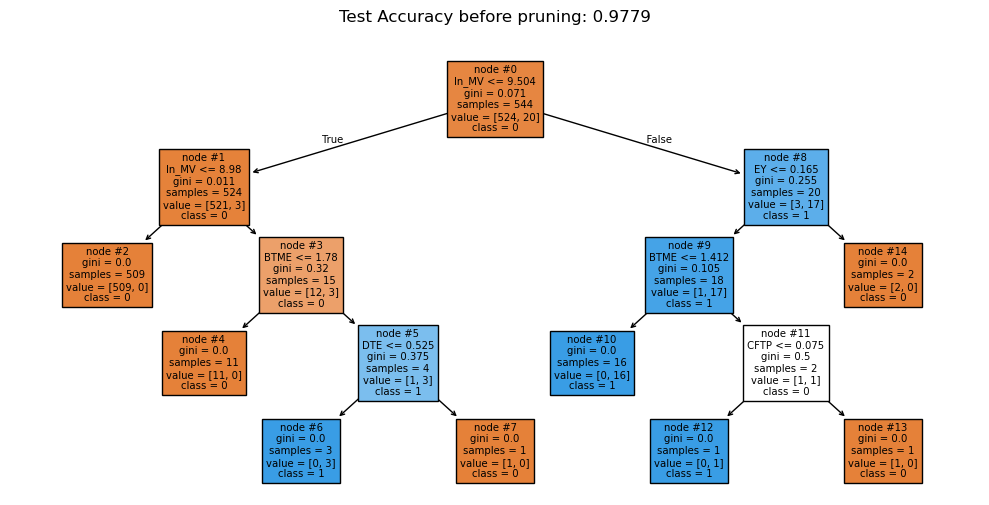

In [23]:
tree_kwargs = {'random_state': random_state,
               'criterion': 'gini',
               'class_weight': None}

base_clf = tree.DecisionTreeClassifier(**tree_kwargs)
base_clf.fit(X_train, y_train)
title = f"Test Accuracy before pruning: {base_clf.score(X_test, y_test):.4f}"
plot_tree(base_clf, title=title, node_ids=True)

#### 2.1.1 Understanding Decision Path

The ```value``` in each node tells how many samples at that node fall into each category. Therefore, the ```value``` will add up to ```sample```.


For example, in node #8, we have 20 samples, 3 class 0, 17 class 1.

Then, we have the rule ```EY <= 0.165``` that splits these 20 samples into [18, 2] (so there could be misclassification).

And ```class``` indicates which class "dominates" (i.e. with highest counts) in that node.

If we want to view the proportion instead of counts, we can set ```plot_tree(clf, proportion=True)```

### 2.2 Minimal Cost-Complexity Pruning

We can see that the tree above is very complicated, and this can likely suffer from overfitting,

therefore, we need a technique called pruning.

\
From ```https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning```,

Given a regularization parameter $\alpha$, We can define a cost-complexity measure $R_{\alpha}(T)$, of a given tree $T$ as:


\begin{equation*}
    R_{\alpha}(T) = R(T) + \alpha |T|
\end{equation*}

where $|T|$ is the number of terminal nodes in and $R(T)$ is defined as the total misclassification rate of the terminal nodes.

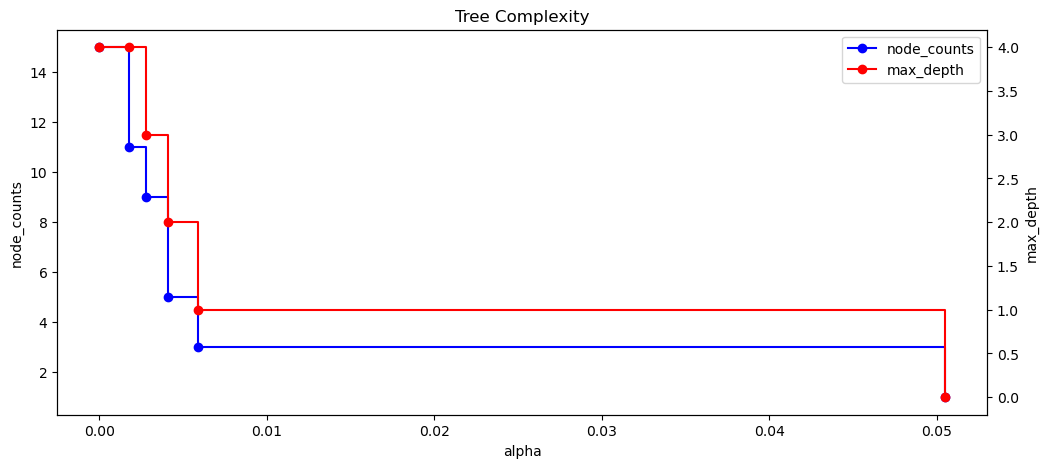

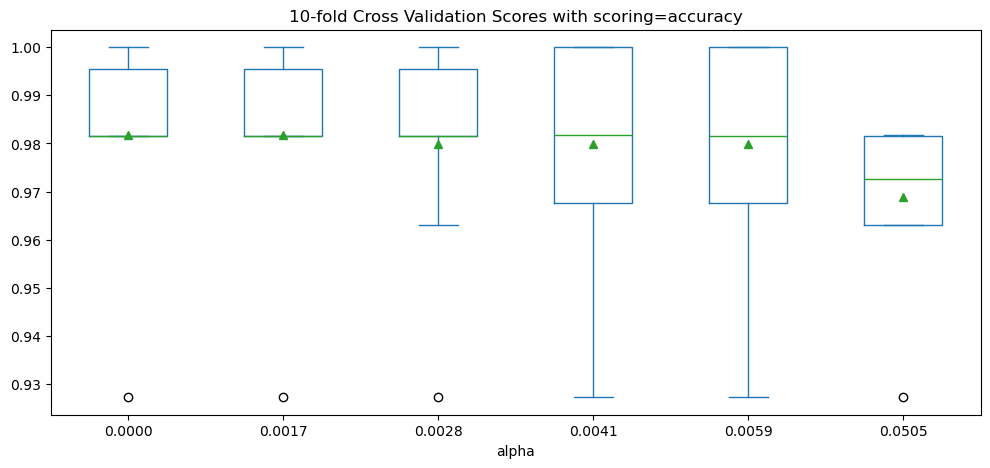

In [28]:
cv = 10
_, clf_dict = cost_complexity_pruning(base_clf, X_train, y_train,
                                   skip_one_node=False, cv=cv, random_state=random_state)

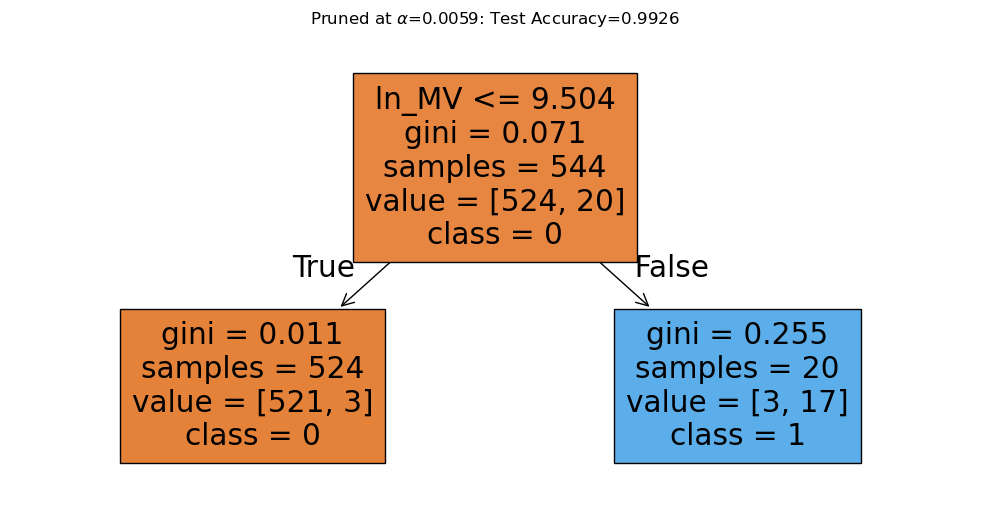

In [29]:
best_alpha = clf_dict['ccp_alpha'][-2]
best_clf = clf_dict['clf'][best_alpha]

title = rf"Pruned at $\alpha$={best_alpha:.4f}: Test Accuracy={best_clf.score(X_test, y_test):.4f}"
plot_tree(best_clf, title=title)

In [30]:
conf_mat, test_stat = confusion_matrix_metrics(best_clf, X_test, y_test)
display(conf_mat, test_stat)

truth,0,1
pred,,
0,124.0,1.0
1,0.0,11.0


,precision,recall,fscore,support
0,0.992,1.000000,0.995984,124
1,1.000,0.916667,0.956522,12


### 2.3 Another Example on Default Dataset

In [32]:
default_df = fetch_r_data(name='Default', package='ISLR')
default_df.default = (default_df.default == 'Yes').astype(int)
default_df.student = (default_df.student == 'Yes').astype(int)
default_df

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879
...,...,...,...,...
9996,0,0,711.555020,52992.378914
9997,0,0,757.962918,19660.721768
9998,0,0,845.411989,58636.156984
9999,0,0,1569.009053,36669.112365


In [33]:
test_size = 0.2
random_state = 12345

X = default_df.drop(columns='default')
y = default_df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [34]:
tree_kwargs = {'random_state': random_state,
               'criterion': 'gini',
               'class_weight': None}

base_clf = tree.DecisionTreeClassifier(**tree_kwargs)
base_clf.fit(X_train, y_train)
print(f"Test Accuracy before pruning: {base_clf.score(X_test, y_test):.4f}")

Test Accuracy before pruning: 0.9665


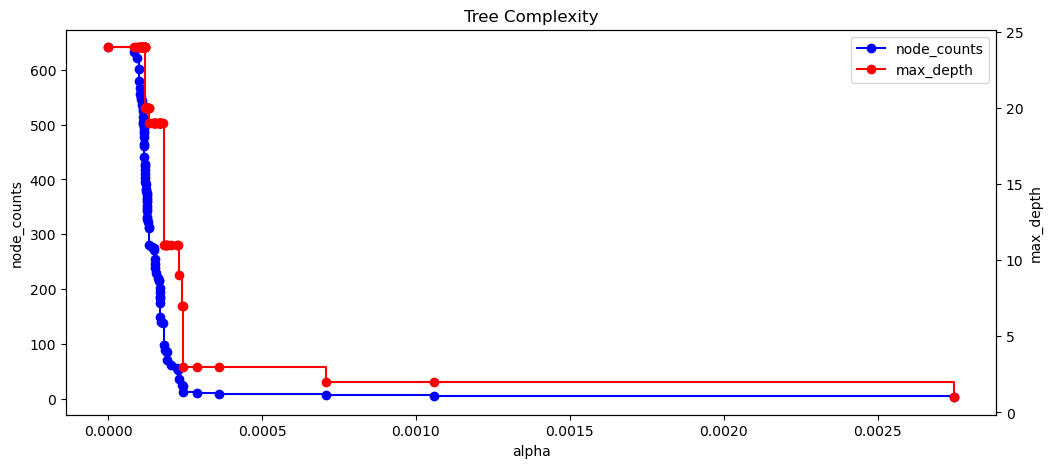

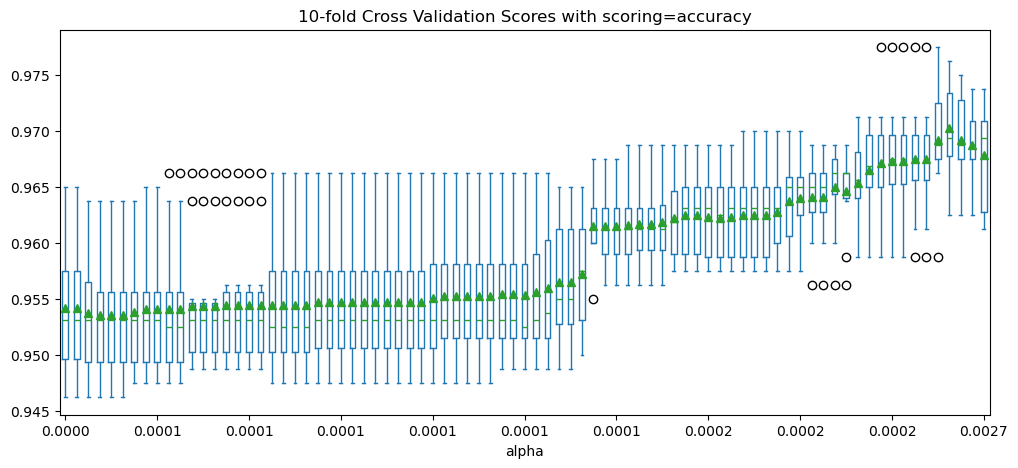

In [35]:
cv = 10
best_alpha, clf_dict = cost_complexity_pruning(base_clf, X_train, y_train, 
                                               skip_one_node=True, cv=cv, random_state=random_state)

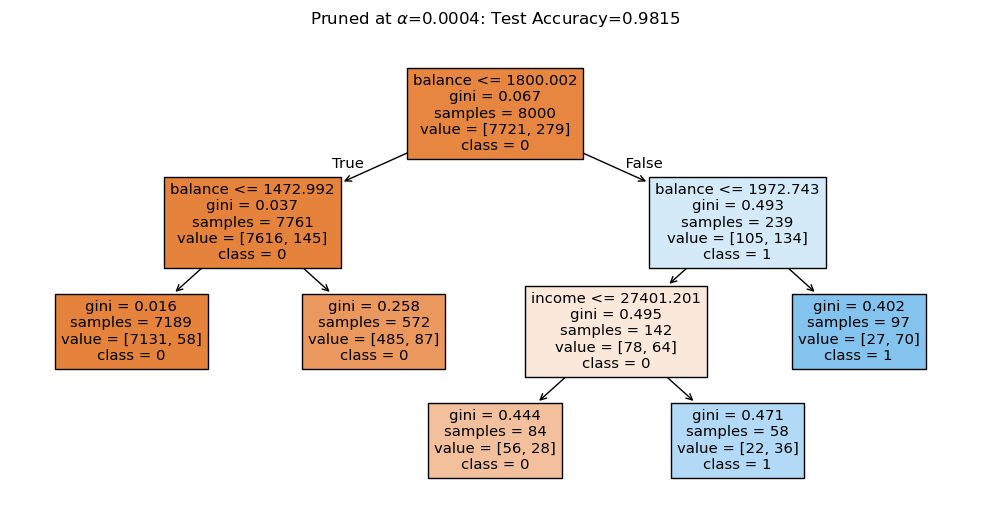

In [36]:
best_clf = clf_dict['clf'][best_alpha]
title = rf"Pruned at $\alpha$={best_alpha:.4f}: Test Accuracy={best_clf.score(X_test, y_test):.4f}"
plot_tree(best_clf, title=title)

In [37]:
conf_mat, test_stat = confusion_matrix_metrics(best_clf, X_test, y_test)
display(conf_mat, test_stat)

truth,0,1
pred,,
0,1939,30
1,7,24


,precision,recall,fscore,support
0,0.984764,0.996403,0.990549,1946
1,0.774194,0.444444,0.564706,54


### 2.4 Note on DecisionTreeClassifier Parameters

In [39]:
clf_doc_str = tree.DecisionTreeClassifier.__doc__

for param in ["criterion", "max_depth", "min_samples_split", "min_samples_leaf"]:
    print_param_doc(clf_doc_str, param)

criterion : {"gini", "entropy", "log_loss"}, default="gini"
        The function to measure the quality of a split. Supported criteria are
        "gini" for the Gini impurity and "log_loss" and "entropy" both for the
        Shannon information gain, see :ref:`tree_mathematical_formulation`.

    
max_depth : int, default=None
        The maximum depth of the tree. If None, then nodes are expanded until
        all leaves are pure or until all leaves contain less than
        min_samples_split samples.

    
min_samples_split : int or float, default=2
        The minimum number of samples required to split an internal node:

    
min_samples_leaf : int or float, default=1
        The minimum number of samples required to be at a leaf node.
        A split point at any depth will only be considered if it leaves at
        least ``min_samples_leaf`` training samples in each of the left and
        right branches.  This may have the effect of smoothing the model,
        especially in re

The above params are the key to what is known as <b>early-stopping</b> or <b>pre-pruning</b> technique.

## 3. Performance Criterion in Classification Tree

When fitting a classification tree, we can assess the obtained rules using three different criteria:

Mathematically, a classification tree partitions the space of feature vectors $\mathcal{D}$ into $M$ disjoint subsets $\mathcal{D}_1,\dots,\mathcal{D}_M$, such that $\mathcal{D}=\overset{M}{\underset{j=1}{\sqcup}}\mathcal{D}_j$, 

which induces a partition $\mathcal{S}_1, \cdots, \mathcal{S}_M$ of $\mathcal{S}$ such that $\mathcal{S}_j:=\{(\boldsymbol{x},y)\in\mathcal{S}:\boldsymbol{x}\in\mathcal{D}_j\}$. 

\
Then, 
1. <b>Support</b>: The support of the set of classification rules that results in $\mathcal{D}_j$ is simply the proportion of observations in $\mathcal{S}_j$ in the entire dataset $\mathcal{S}$:
	\begin{equation*}
		{\rm Support}_j = \frac{|\mathcal{S}_j|}{|\mathcal{S}|} \, .
	\end{equation*}

2. <b>Confidence</b>: Recall that the predicted label in a subset $\mathcal{S}_j$ is determined by a majority voting, to this end we denote $m_j := \text{argmax}_{y} |\{(\mathbf x_i, y_i) \in \mathcal{S}_j: y_i = y\}|$ as the majority label in $\mathcal{S}_j$. Then, the confidence of the set of classification rules that results in $\mathcal{D}_j$ is the proportion of correctly classified cases in $\mathcal{S}_j$:
	\begin{equation*}
		{\rm Confidence}_j = \frac{|\{(\mathbf x_i, y_i) \in \mathcal{S}_j: y_i=m_j\}|}{|\mathcal{S}_j|} \, .
	\end{equation*}


3. <b>Capture</b>: The capture of the set of classification rules that results in $\mathcal{D}_j$ is the proportion of observations in $\mathcal{S}_j$, whose labels are the same as the majority label $m_j$ in $\mathcal{S}_j$, among those in the entire dataset $\mathcal{S}$ with the same label $m_j$:
	\begin{equation*}
		{\rm Capture}_j = \frac{|\{(\mathbf x_i, y_i) \in \mathcal{S}_j: y_i=m_j\}|}{|\{(\mathbf x_i, y_i) \in \mathcal{S}: y_i=m_j\}|} \, .
	\end{equation*}

### 3.1 Example on Default Tree

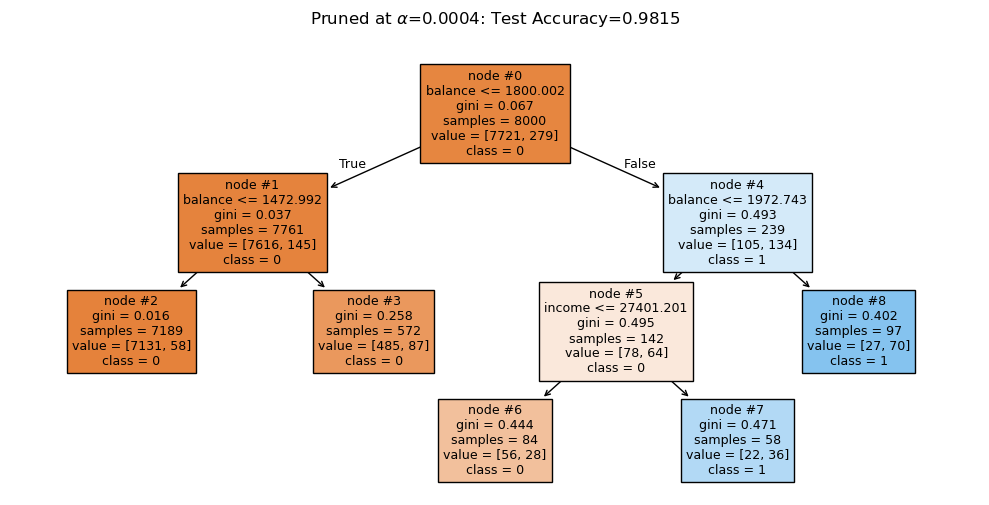

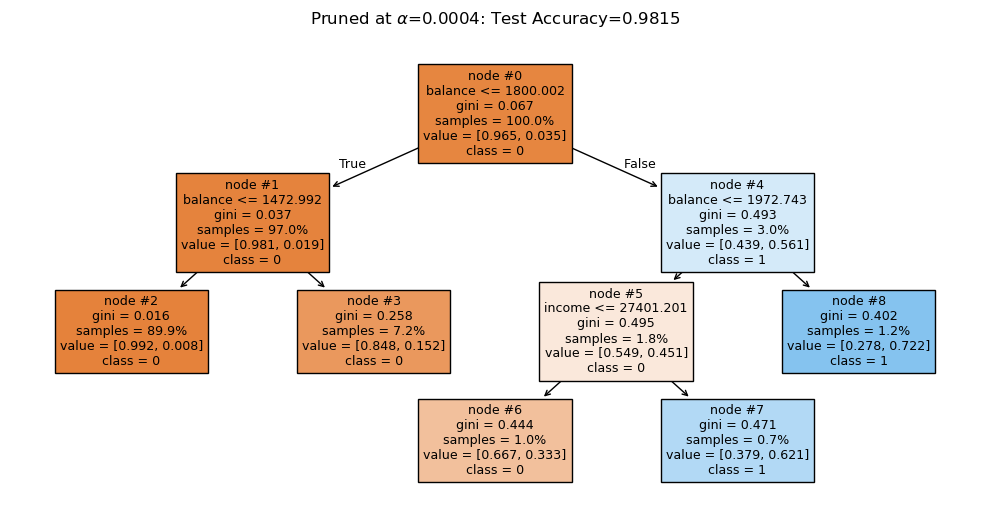

In [44]:
plot_tree(best_clf, node_ids=True, title=title)
plot_tree(best_clf, node_ids=True, proportion=True, title=title)

There are 5 terminal nodes. We will demonstrate node #2, #3, #7.

In node #2, 
1. Support $= \frac{7189}{8000} = 89.9 \%$
2. Confidence $= \frac{7131}{7189} = 99.2 \%$
3. Capture $= \frac{7131}{7721} = (\frac{7131}{7189})(\frac{7189}{8000}) / (\frac{7721}{8000}) = 92.4 \%$

\
In node #3, 
1. Support $=7.2 \%$
2. Confidence $=84.8\%$
3. Capture $= (7.2\%)(84.8\%) / (96.5\%) = 6.33 \%$

\
In node #7, 
1. Support $= 0.7 \%$
2. Confidence $= 62.1 \%$
3. Capture $= (0.7\%)(62.1\%) / (3.5\%) = 12.4 \%$